# Tumor/Normal classification from Single-Cell gene expression data

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import scanpy as sc


from sklearn.model_selection import train_test_split, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import *

/Users/giovannanicora/.conda/envs/untitled/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
path_anno = '/Users/giovannanicora/Documents/single-cell_hierarchies/GSM3587932_AML328-D0.anno.txt'
anno = pd.read_csv(path_anno, sep='\t')

In [3]:
anno.columns
print(Counter(anno.PredictionRefined))
print(Counter(anno.CellType))

Counter({'malignant': 693, 'normal': 401})
Counter({'Prog-like': 281, 'Mono-like': 214, 'HSC-like': 143, 'T': 108, 'Mono': 79, 'NK': 75, 'cDC-like': 52, 'earlyEry': 44, 'CTL': 22, 'HSC': 19, 'cDC': 12, 'B': 12, 'lateEry': 9, 'Prog': 8, 'Plasma': 7, 'ProMono': 3, 'GMP-like': 2, 'pDC': 2, 'ProMono-like': 1, 'ProB': 1})


In [4]:
# Myeloid cells
mcells = ['HSC', 'Prog', 'GMP', 'Promono', 'Mono', 'cDC', 'pDC']

# Selecting only myeloid cells (normal or tumor)
ind_myeloid_malign = [i for i,x in enumerate(anno.CellType) if 'like' in x]
ind_myeloid_benign = [i for i,x in enumerate(anno.CellType) if x in mcells]

In [5]:
len(ind_myeloid_benign)

120

In [6]:
len(ind_myeloid_malign)

693

In [7]:
df = pd.read_csv('/Users/giovannanicora/Documents/single-cell_hierarchies/AML328-D0.dem.txt',
                 sep='\t')

In [9]:
df.shape

(27899, 1095)

In [8]:
#df.head()
gene_names = df['Gene']
# Selecting only Myeloid
barcodes_myeloid = list(anno.Cell[ind_myeloid_malign])+list(anno.Cell[ind_myeloid_benign])
m_col = [i for i,x in enumerate(df.columns) if x in barcodes_myeloid]
df = df.iloc[:, m_col]
df.shape

(27899, 813)

In [9]:
barcodes = [x for x in df.columns if 'Gene' not in x]
anndata = sc.AnnData(X=df.T.to_numpy(), obs=barcodes, var=gene_names.values)

In [10]:
anndata.var_names = gene_names.values

In [11]:
anndata.obs_names = barcodes

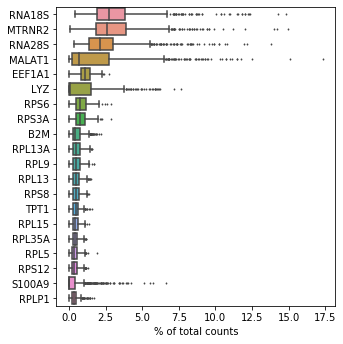

In [12]:
anndata.raw = anndata
sc.pl.highest_expr_genes(anndata, n_top=20, )

In [13]:
anndata.shape

(813, 27899)

In [14]:
# Normalization and filtering
sc.pp.filter_genes(anndata, min_cells=10)

In [15]:
anndata.shape

(813, 10814)

In [16]:
sc.pp.normalize_total(anndata, target_sum=1e4)
sc.pp.log1p(anndata)

In [17]:
np.max(anndata.raw.X)
np.max(anndata.X)

7.8119555

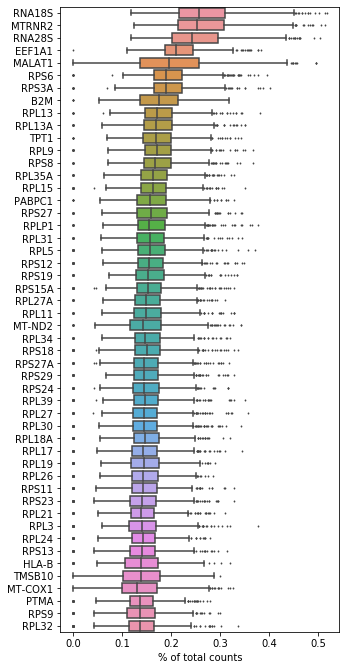

In [18]:
sc.pl.highest_expr_genes(anndata, n_top=50, )

## Machine Learning

In [19]:
barcodes2class = dict(zip(anno.Cell,
                          anno.PredictionRefined))
y_true = [barcodes2class[x] for x in anndata.obs_names]
X = anndata.X
X_train = X
classdict = dict(normal=0, malignant=1)
y_true_num = [classdict[x] for x in y_true]
y_train = np.array(y_true_num)

POP on training set

In [20]:
# POP on the training set
from pop_implemetation import *

(mind_train, maxd_train, isborder_train, attr2outerb_train, attr2innerb_train,
 attr2outerb_train_val, attr2innerb_train_val) = pop_instance_training(X_train, y_train)
train_border_examples = X_train[np.argwhere(np.sum(np.abs(isborder_train), axis=1)!=0).ravel(),:]
ytrain_border_examples = y_train[np.argwhere(np.sum(np.abs(isborder_train), axis=1)!=0).ravel()]

In [21]:
mind_train

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
maxd_train

array([2.43459916, 2.99359727, 2.96523499, ..., 3.04072094, 2.99720597,
       2.92429781])

In [23]:
clf_svm = SVC()
scores_svm = cross_validate(clf_svm, X_train, 
                        y_train, 
                        scoring={'accuracy_score':make_scorer(accuracy_score),
                                 'precision_score':make_scorer(precision_score),
                                 'prc':make_scorer(average_precision_score),
                                 'mcc':make_scorer(matthews_corrcoef)})
from sklearn.linear_model import LogisticRegression
clf_lr =  LogisticRegression(penalty='l1', solver='liblinear') # Lasso
scores_lr = cross_validate(clf_lr, X_train, 
                        y_train, 
                        scoring={'accuracy_score':make_scorer(accuracy_score),
                                 'precision_score':make_scorer(precision_score),
                                 'prc':make_scorer(average_precision_score),
                                 'mcc':make_scorer(matthews_corrcoef)})

                                    

/Users/giovannanicora/.conda/envs/untitled/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/giovannanicora/.conda/envs/untitled/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/giovannanicora/.conda/envs/untitled/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/giovannanicora/.conda/envs/untitled/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/giovannanicora/.conda/envs/untitled/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarnin

In [24]:
# Training on the entire training set
clf_svm.fit(X_train, y_train)
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
scores_svm

{'fit_time': array([6.32129407, 5.30457187, 5.32220602, 6.53241301, 6.61290216]),
 'score_time': array([1.04474211, 1.06900096, 1.16953397, 1.50716424, 1.448246  ]),
 'test_accuracy_score': array([0.85276074, 0.85276074, 0.85276074, 0.85185185, 0.85185185]),
 'test_precision_score': array([0.85276074, 0.85276074, 0.85276074, 0.85185185, 0.85185185]),
 'test_prc': array([0.85276074, 0.85276074, 0.85276074, 0.85185185, 0.85185185]),
 'test_mcc': array([0., 0., 0., 0., 0.])}

In [26]:
scores_lr

{'fit_time': array([0.11258912, 0.12265325, 0.12079835, 0.10996389, 0.18831396]),
 'score_time': array([0.00680304, 0.00878692, 0.00614882, 0.00666189, 0.00661612]),
 'test_accuracy_score': array([0.87116564, 0.88343558, 0.85889571, 0.90740741, 0.83950617]),
 'test_precision_score': array([0.88815789, 0.90540541, 0.9084507 , 0.94244604, 0.88356164]),
 'test_prc': array([0.88713927, 0.90351171, 0.90444423, 0.93785069, 0.88149361]),
 'test_mcc': array([0.37133718, 0.46667465, 0.40868253, 0.62692225, 0.26963712])}

In [27]:
[np.mean(scores_svm[x]) for x in scores_svm.keys() ]

[6.018677425384522,
 1.247737455368042,
 0.8523971824585322,
 0.8523971824585322,
 0.8523971824585322,
 0.0]

In [28]:
[np.mean(scores_lr[x]) for x in scores_lr.keys() ]

[0.13086371421813964,
 0.007003355026245117,
 0.8720821025524502,
 0.9056043382737368,
 0.9028879030003706,
 0.4286507478252567]

### Predicting on a Validation dataset
We try to predict the class of new unseen examples

*Obs*: first of all we need to correct for batch effect
